# Problem 1 : Bus Fleet

# Import the necessary libraries

The following cell holds all the necessary libraries to run this notebook.
You can change this notebook as you please.

In [70]:
# Visualization of the problem graph
import matplotlib.pyplot as plt
import networkx as nx

# Matricial computation and calssical optimization
import numpy as np
from scipy.optimize import minimize

# Creation of quantum circuits
from qiskit import QuantumCircuit

# Structure used to build Hamiltonians
from qiskit.quantum_info import SparsePauliOp

# Method used to create QAOA circuits to optimize
from qiskit.circuit.library import QAOAAnsatz

# Tools used for the execution of quantum circuits
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Transpilation of quantum circuits on IBM's simulators and quantum computers
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Quantum computer simulator
from qiskit_aer import AerSimulator

# Simulators of existing quantum computers
from qiskit_ibm_runtime.fake_provider import FakeNairobiV2  # , FakeQuebec

# Visualization of probablity distributions
from qiskit.visualization import plot_histogram

# Introduction

The Société de Transport de Sherbrooke (STS) is facing an optimisation problem linked to the organization of the bus fleet deployed in town. We are presenting you a simplified case to experiment the resolution of a combinatorial optimization problem using the quantum alorithm called **QAOA**.

## Problem statement

> The STS wishes to add 5 buses each serving a different line, to accomodate the growing need felt by users for the morning departures of 08:00 am and 08:30. Given that some bus lines intersect, we want to organize the buses into 2 groups. Ideally, we want the buses serving the same stops to depart at different times as much as possible.

To model this problem, we represent each bus by a node in a graph. An edge between two nodes represents the fact that the two buses serve at least one common stop.

<p align="center">
<img src="figures/img_probleme_1.jpg" alt="probleme 1" width="150"/>
</p>

The bus lines are represented as nodes in the graph while edges correspond to common stops.



The two departure times, 08:00am and 08:30am, are identified by colors: orange (0) and indigo (1) respectively.

<p align="center">
<img src="figures/graphe_partition.jpeg" alt="probleme 1" width="150"/>
</p>


## MaxCut Problem
When two bus lines with at least a common stop are partitioned by departure time, their corresponding edge is *cut*. A **cut** is the set of all cut edges. The cut containing the largest number of edges is the ***maximal cut*** (maxcut).

<p align="center">
<img src="figures/graphe_coupe.jpeg" alt="probleme 1" width="150"/>
</p>

## Encoding
We define the departure time color of a bus by the variable $m_i$ where $i \in S = \{0,1,2,3,4\}$.

We will use the indices $\{ 0,1,2,3,4\}$ to represent the bus lines $\{ 7, 12, 16, 11, 3\}$, respectively.

Thus, if the departure time of bus line 7 is orange, $m_0=0$, meanwhile if it were indigo, $m_0=1$.

Example<br>
the vector $M = [m_0, m_1, m_2,m_3,m_4]$ would be $M=[1,0,0,1,0]$ for the cut in the previous section.

## Cost of a cut
To find the maxcut, we define the function $g(i,j)$ which takes as input the indices of the two nodes at each end of an edge, and returns $+1$ if $m_i=m_j$, or $-1$ if $m_i \neq m_j$. We denote the set of all edges by the letter $L$.

$L = \{ (0,1), (0,3), (0,4),(1,2),(1,4),(2,3) \}$<br>
$g(0,3)=g(1,2)=g(1,4)=+1$<br>
$g(0,1)=g(0,4)=g(2,3)=-1$

The maximal cut is obtained by minimizing the function $G=\sum_{i,j\in L}g(i,j)$.


## Brute force method
Try all the configurations and choosing the best one.

For a problem with 5 nodes
> $2^5=32$ configurations

For a problem with 100 nodes
> $2^{100} \sim 10^{30}$ configurations (that's 1267650600228229401496703205376 configurations...)

## Quantum cost function
We associate a qubit to each node and we prepare the state $|\psi\rangle = |q_4q_3q_2q_1q_0\rangle$ where $q_i \in \{ 0,1\}$.<br>
Thus we can implement the cost function $G=\sum_{i,j\in L}g(i,j) = \langle H \rangle_{\psi}=\sum_{i,j\in L}\langle Z_i Z_j \rangle_{\psi}$.

In [71]:
H = SparsePauliOp(
        data=["IIIZZ",
              "IZIIZ",
              "ZIIIZ",
              "IIZZI",
              "ZIIZI",
              "IZZII"]
                )
print(H)

SparsePauliOp(['IIIZZ', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'ZIIZI', 'IZZII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


Average value 0.0000


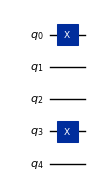

In [72]:
# Test the configuration |psi> = |01001> (bus line 7 and 11 in the same departure group)
qc = QuantumCircuit(5)
qc.x(0)
qc.x(3)

simulator = AerSimulator()
sampler = Sampler(simulator)
estimator = Estimator(simulator)

result = estimator.run([(qc, H)]).result()

print(f"Average value {result[0].data.evs:.4f}")
qc.draw('mpl', scale=0.5)

Average value 2.0000


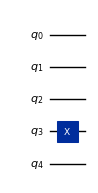

In [73]:
# Test the configuration |psi> = |01000> (every bus lines but bus line 11 are in the same departure group)
qc = QuantumCircuit(5)
qc.x(3)

result = estimator.run([(qc, H)]).result()

print(f"Average value {result[0].data.evs:.4f}")
qc.draw('mpl', scale=0.5)

Average value 0.9688


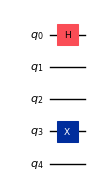

In [74]:
# Test the configuration |psi> = 1/sqrt(2)(|01001> + |01000>)
# (The solutions where
# 1. bus line 11 is one group
# 2. and the one where bus line 7 and 11 form a group
# are both equally good solutions)

qc = QuantumCircuit(5)
qc.h(0)
qc.x(3)

result = estimator.run([(qc, H)]).result()

print(f"Average value {result[0].data.evs:.4f}")
qc.draw('mpl', scale=0.5)



## Quantum parallellism
At the end of the day, we want to find the circuit that prepares the quantum state which minimizes the average value of the cost function $G$.

<!-- <p align="center">
<img src="figures/img_probleme_1.jpg" alt="probleme 1" width="150"/>
</p>
<p align="center">
<img src="figures/img_probleme_1.jpg" alt="probleme 1" width="150"/>
</p>
<p align="center">
<img src="figures/img_probleme_1.jpg" alt="probleme 1" width="150"/>
</p> -->

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="figures/qparallel1.png" width="420">
    <br>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="figures/qparallel2.png" width="420">
    <br>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="figures/qparallel3.png" width="420">
    <br>
  </p> 
</td>
</tr></table>


## Display the graph with Python (optional)
The Networkx library is used to visualize the graph corresponding to the problem. The given code can also be used for other problems or for your own explorations!
You can also add weights to edges and display it on the visualization, but these options are disabled by default here.

The visualization of the problem graph is optional here, but it may help you in to solve this problem, or you can use it for the main challenge!

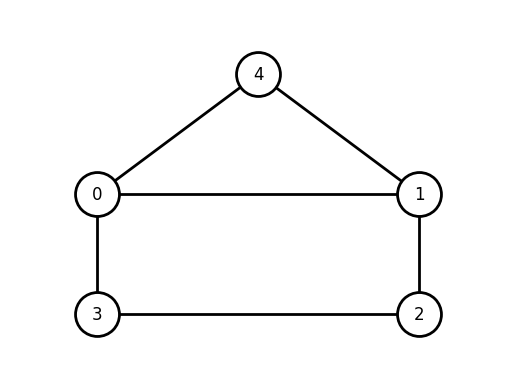

In [75]:
# Instanciate a graph with Networkx
G = nx.Graph()
# Add the graph edges and weights, as needed. A list of the form [(node_A, node_B, edge_weight_AB), ...].
G.add_weighted_edges_from([(0, 1, 1), (1, 2, 1), (2, 3, 1), (3, 0, 1), (0, 4, 1), (4, 1, 1)])
# Define the positions of each nodes to draw the graph
pos = {0: (-1, 0), 1: (1, 0), 2: (1, -1), 3: (-1, -1), 4: (0, 1)}
# Define visualization options
options = {"node_size": 1000, "node_color": "white", "edgecolors": "black", "linewidths": 2, "width": 2}
# Draw graph
nx.draw_networkx(G, pos, **options)
# Draw graph with each edge weight if needed
# nx.draw_networkx_edge_labels(G, pos, nx.get_edge_attributes(G, "weight"))

# Display graph visualization
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

# Cost function
Before attempting to solve the problem with QAOA, we first need to define the cost function representing our optimization goal.

## Qubits and average values

The bus distribution problem must be formulated in terms of qubits and quantum logic gates in order to be solved with a quantum algorithm like **QAOA**. Each node in the graph represents a bus, and we will use one qubit to encode each node. Thus, the number of qubits in our circuit corresponds to the number of nodes (or buses!) in our graph.

To capture the relationships between nodes, we define the interactions between qubits using edge information. For example, a Pauli string such as $IIIZZ$ encodes an edge between qubits (nodes) 0 and 1, where each Pauli matrix $Z_i$ corresponds to a measurement on a qubit $i$.

When qubits 0 and 1 are in the same group, the observable $IIIZZ$ associated to this edge will take the value $1$. If the two qubits are in different groups, the observable will take the value $-1$. This encoding lets us know if two nodes (buses) are partitioned correctly.

## Writing the Hamiltonian

The Hamiltonian representing the problem's cost function, is expressed as a sum of Pauli strings associated to each pair of qubits connected by an edge in the graph. For two qubits $i$ and $j$ connected by an edge, the interaction is modeled by a term $Z_i Z_j$.

Hence, the Hamiltonian for the whole graph is:

$$
H = \sum_{(i,j) \in E} Z_i Z_j
$$

where $E$ is the set containing all the edges in the graph. This sum covers all pairs of nodes $i$ and $j$ sharing an edge i.e. the set of buses sharing a common stop at the very least.
> The goal is to minimize this function to partition optimally the buses into two groups.

**Note :** This is equivalent to a simple Max-Cut problem.

We use the structure `SparsePauliOp` to instantiate a Hamiltonian.

In [76]:
# Instantiate a SparsePauliOp as a sum of Pauli strings each mutliplied by a specific coefficient (here 1).
H = SparsePauliOp.from_list(
    [("IIIZZ", 1.0), ("IIZZI", 1.0), ("IZZII", 1.0), ("IZIIZ", 1.0), ("ZIIIZ", 1.0), ("ZIIZI", 1.0)]
)
#Display the SparsePauliOp
print(H)

SparsePauliOp(['IIIZZ', 'IIZZI', 'IZZII', 'IZIIZ', 'ZIIIZ', 'ZIIZI'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


# Classical verification

The problem can be solved using matrix representation. Given the small size of the problem, it is possible to diagonalize its matrix to uncover the exact solution. You can use this diagonalization method to verify the validity of your quantum solution.

**Note:** You can explore the optional `problemes_utils.py` file, which contains useful methods to help you: compute the exact solution (as shown below), evaluate the score of a given solution, and save your results.

In [77]:
def compute_exact_sol(hamiltonian: SparsePauliOp) -> tuple[float, list[str]]:
    """ Classical computation of the inputted Hamiltonian's solutions.
        Done by diagonalizing the Hamiltonian's matrix representation.

    Args:
        Hamiltonian (SparsePauliOp): Hamiltonian to diagonalize, expressed as a sum of Pauli strings.

    Returns:
        tuple[float, list[str]]:
            - minimal cost obtained (float)
            - List of the binary solutions associated to the minimal cost
    """
    # Write the Hamiltonian as a matrix
    mat_hamiltonian = np.array(hamiltonian.to_matrix())
    # Diagonalize the matrix to extract the eigenvectors and eigenvalues
    eigenvalues, eigenvects = np.linalg.eig(mat_hamiltonian)

    # Indices associated to the minimal eigenvalues
    min_eigenval = np.where(eigenvalues == np.min(eigenvalues))[0]
    # Minimal solutions associated to the minimal eigenvalues
    binary_sols = [bin(idx).lstrip("-0b").zfill(hamiltonian.num_qubits) for idx in min_eigenval]

    # Cost and binary strings of the best solutions
    return eigenvalues[min_eigenval][0].real, binary_sols

In [78]:
# Check if the Hamiltonian we found gives the expected solution
minimal_cost, binary_sols = compute_exact_sol(hamiltonian=H)

# Display the minimal cost we obtained
print("Minimal cost : ", minimal_cost)
# Display the binary solutions (read right to left, from qubit 0 to qubit 4)
for i, sol in enumerate(binary_sols):
    print("Minimal cost solution {idx} : {solution}".format(idx=i, solution=sol))

Minimal cost :  -4.0
Minimal cost solution 0 : 00101
Minimal cost solution 1 : 01010
Minimal cost solution 2 : 10101
Minimal cost solution 3 : 11010


# Fine-tuning QAOA
QAOA (Quantum Approximate Optimization Algorithm) is a quantum variational algorithm, used here to solve our combinatorial optimization problem. 

Your goal is to fine-tune the hyperparameters of your hybrid algorithm to solve the bus fleet organisation problem efficiently. The hyperparameters you need to adjust are:

- The number of layers in the QAOA circuit.

- The QAOA circuit parameters (i.e. the rotation angles).

- The options of the classical optimizer used to update QAOA's parameters during the optimization loop.

## QAOA Circuit
In the following cells, you will find the proposed structure to build the QAOA circuit based on the problem's Hamiltonian. Experiment with the number of layers to improve the approximation of the solution.

Note: Too small a number of layers may result in unstable solutions, meanwhile too large a number of layers will considerably increase execution time. Ideally, you need to strike a balance which will efficiently amplify the solutions without needlessly complexifying the simulation (i.e. Aim for a reasonable execution time on a laptop).

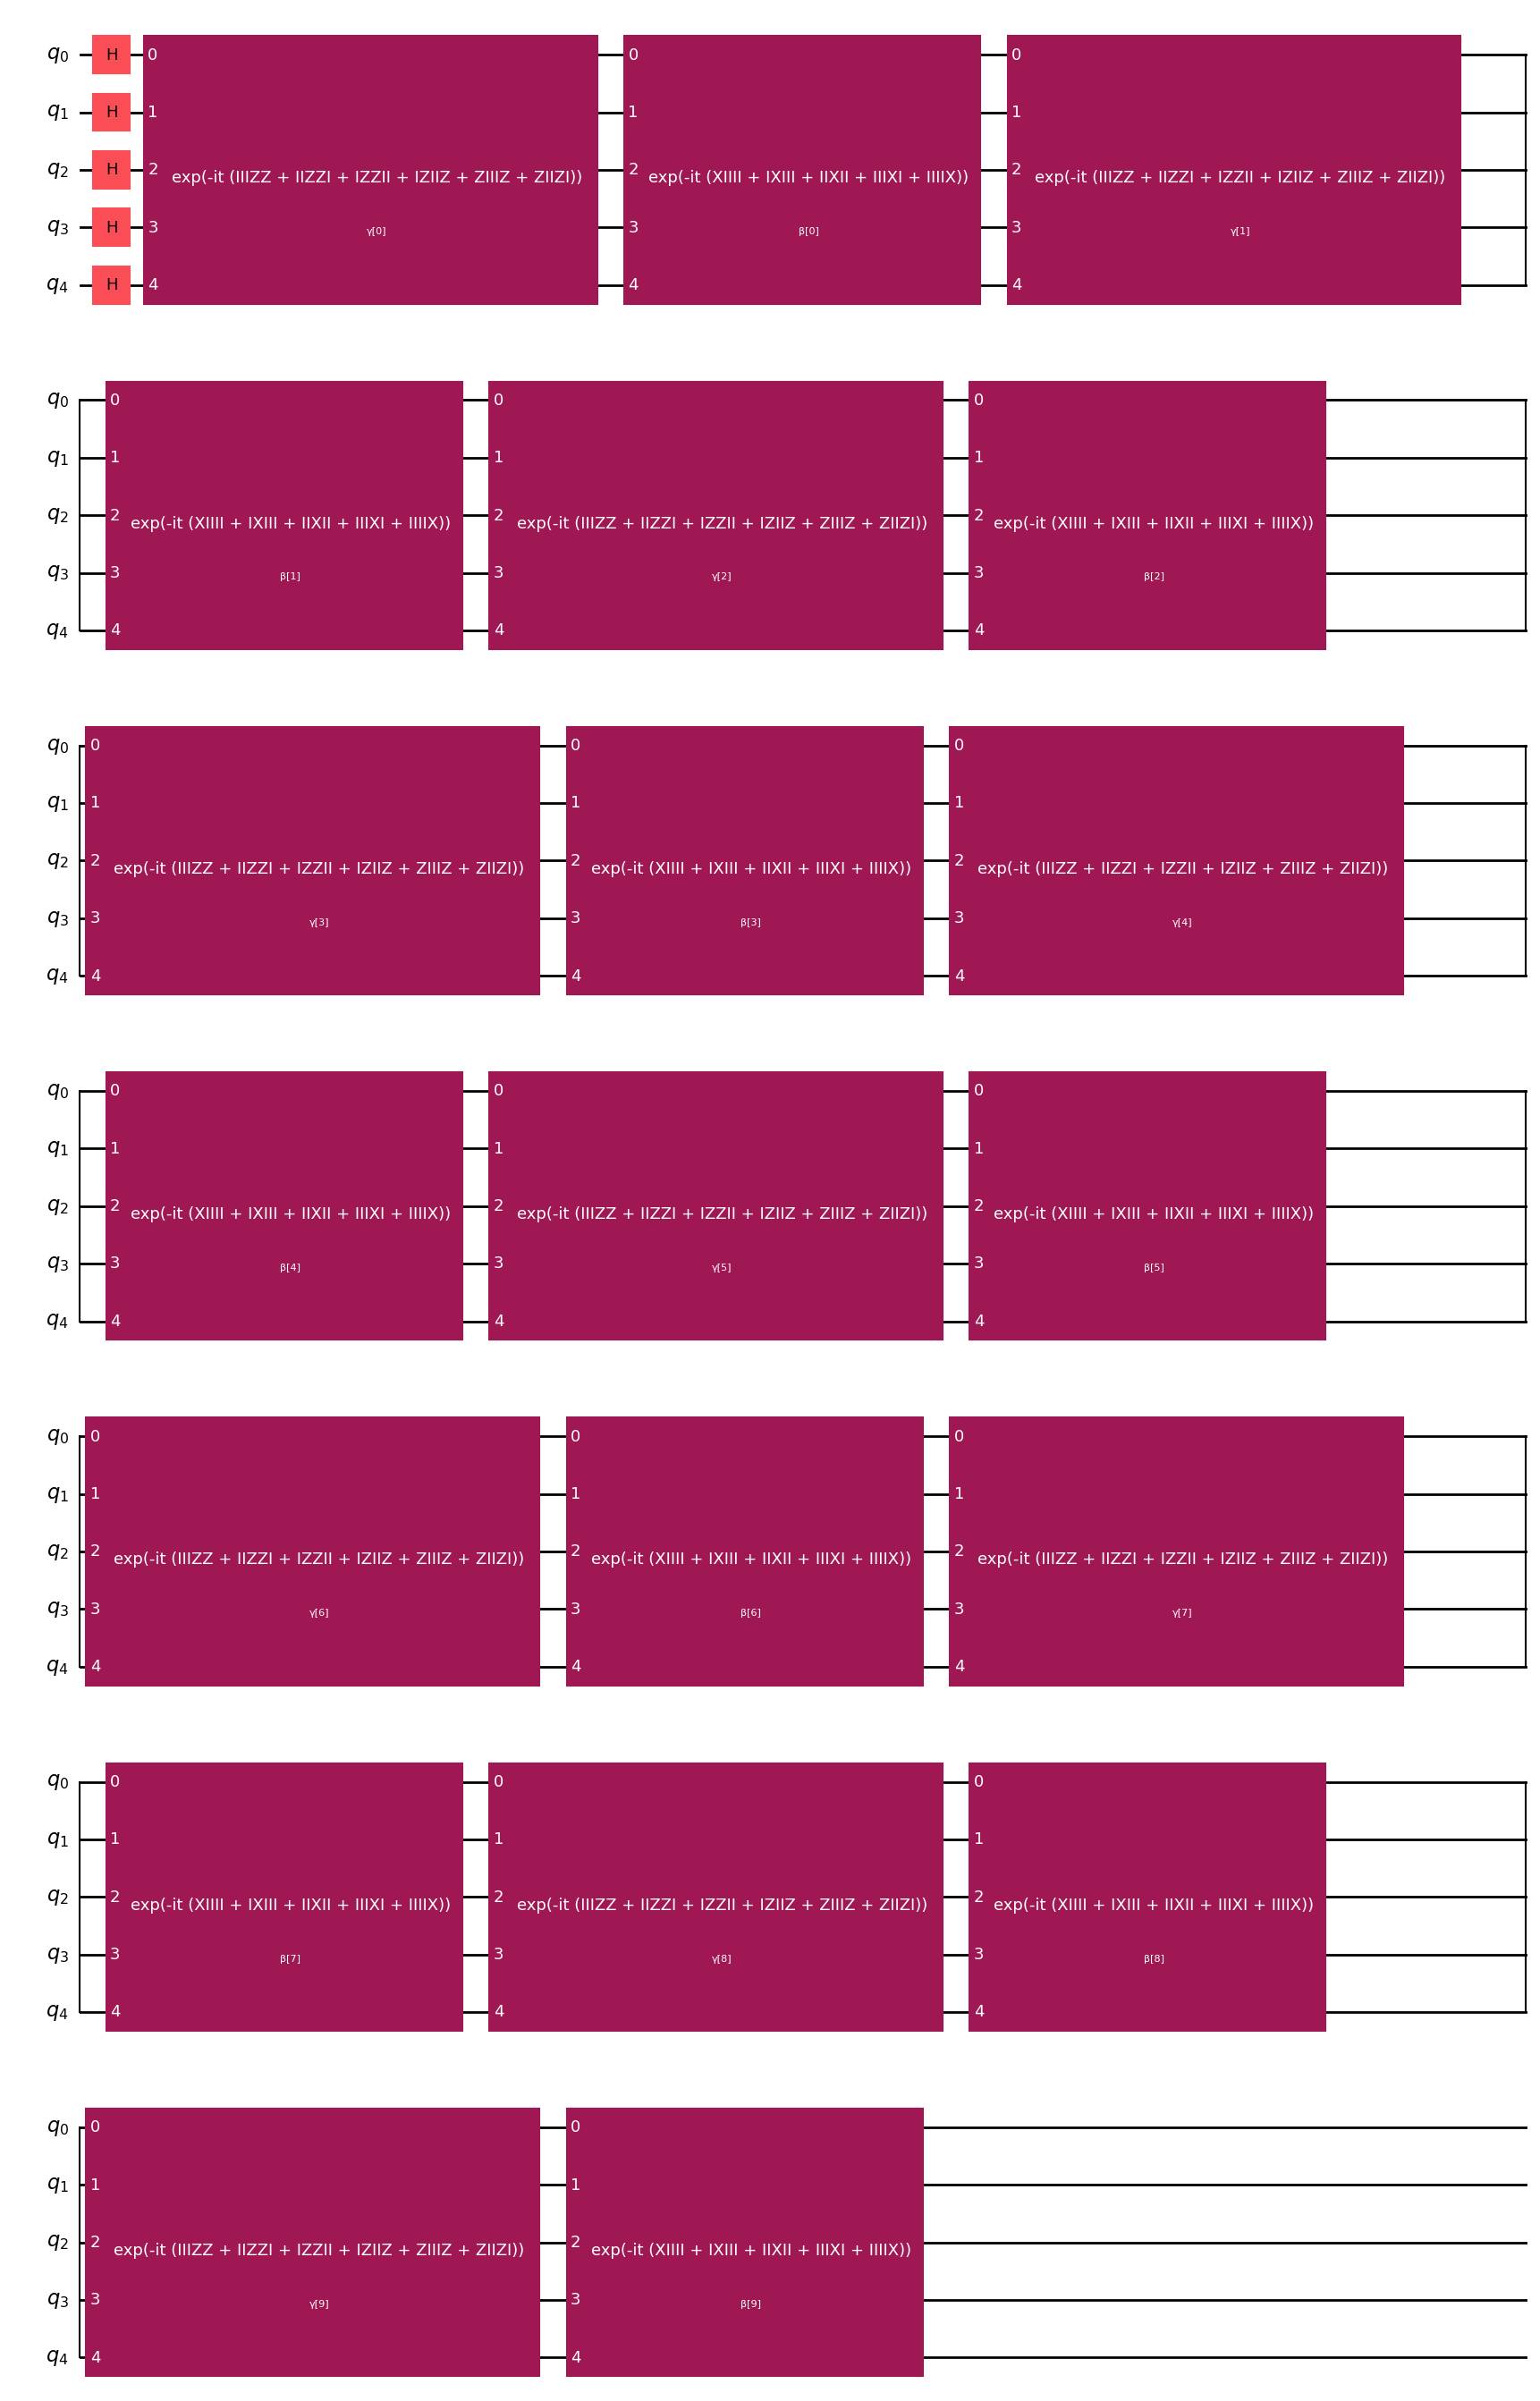

In [79]:
# Identify the number of layers (repetitions) for QAOA
nb_layers = 10  # Modifier comme il vous plait

# Instantiate the QAOA circuit with Qiskit's implementation
circuit_qaoa = QAOAAnsatz(H, reps=nb_layers)

# Display the QAOA circuit if you want :-)
circuit_qaoa.decompose(reps=1).draw(output="mpl", style="iqp")

In [80]:
# Define a simulator to compute average values
backend = AerSimulator()  # Can be changed for different simulators or a real quantum backend, if desired
estimator = Estimator(mode=backend)

# Define a transpilation tool needed by Qiskit to run the simulation.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

In [81]:
# Define the classical cost function to optimize
def cost_function(
    params: list[complex], estimator: Estimator, circuit: QuantumCircuit, hamiltonian: SparsePauliOp
) -> float:
    """
    Cost function that computes the average value of an observable ('hamiltonian') for a given state ('circuit').
    This average value represents the cost function described by the input Hamiltonian. Also, the
    parametrized circuit and its parameters are defined in the 'params' vector.
    Everything is evaluated by the estimator.

    Args:
        params (list[complex]): List of parameters to be inserted in 'circuit'.
        estimator (Estimator): Estimates the desired average values.
        circuit (QuantumCircuit): QAOA's parametrized circuit.
        hamiltonian (SparsePauliOp): Observable associated to the problem's cost function

    Returns:
        float: Cost associated to the input parameters.
    """
    isa_psi = pm.run(circuit)
    isa_observables = hamiltonian.apply_layout(isa_psi.layout)

    job = estimator.run([(isa_psi, isa_observables, params)])
    cost = job.result()[0].data.evs
    return cost

## QAOA circuit parameters

The following cell enables the optimization of the classical parameters (rotation angles) of QAOA circuit. These parameters are initialized with a vector of zeros, but it might be a *(very)* good idea to explore other initialization schemes to improve optimization results.

### Classical optimizer
The **Cobyla** optimizer is proposed to update the parameters by minimizing the cost function discussed previously. You are free to modify Cobyla's options or try another optimizer you find more appropriate.

Some gradient-free optimizers are implemented directly in `Qiskit`.

In [82]:
# QAOA circuit parameter initialization 
params_init = np.random.random(circuit_qaoa.num_parameters)

# Classical optimization of QAOA circuit using Scipy
res_opt = minimize(
    cost_function, params_init, args=(estimator, circuit_qaoa, H), method="COBYLA"
)  # , options={"tol": 1e-14}

# Information extraction following optimization
cost_opt = res_opt.fun  # Optimal cost evaluated
params_opt = res_opt.x  # Optimal parameters evaluated

# Displaying the results 
print("Optimal cost found :", cost_opt)
print("Optimal parameters found :", params_opt)

Optimal cost found : -3.3740234375
Optimal parameters found : [-0.19937444  0.01417229  0.33153845  0.74198817  0.69325246  0.3256236
  0.93850648  0.93120469  0.45965596  0.77815933  0.09039554  0.98191634
  0.15206726  0.38932641  0.89926809  1.89853294  0.88468606  0.0702862
  0.36974846  0.18692738]


# Identifying the Solutions

After determining an optimal number of layers and an optimal vector of parameters, a **sampler** is used to generate the probability distribution associated to this optimal QAOA circuit instance.

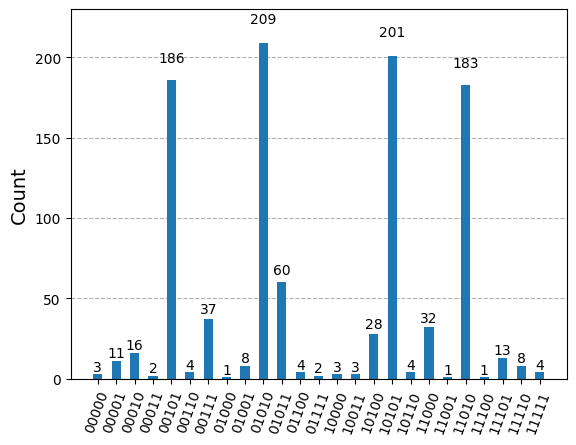

In [83]:
# Instanciate a Sampler to obtain a probability distribution
sampler = Sampler(mode=backend)

# Compute the probability distribution with the optimal parameters that you found previously
circuit_qaoa_copy = circuit_qaoa.decompose(reps=2).copy()
circuit_qaoa_copy.measure_all()
circuit_qaoa_copy.draw()
counts = sampler.run([(circuit_qaoa_copy, params_opt)]).result()[0].data.meas.get_counts()
# Display the probability distribution
plot_histogram(counts)

# Classical solutions
# Minimal cost solution 0 : 00101
# Minimal cost solution 1 : 01010
# Minimal cost solution 2 : 10101
# Minimal cost solution 3 : 11010

## Goal: Find all the solutions by fine-tuning QAOA
Your mission is to find the best solutions to the Bus Fleet Problem by optimizing the hyperparameters of the QAOA circuit.

You are given the QAOA solution pipeline, but you must find the best circuit parameters, and the optimal number of circuit layers, in order to find the optimal solutions.

### Evaluation
1. Show a mentor the solutions you were able to find with your optmized QAOA circuit

2. Run your algorithm in front of a mentor or show cell outputs demonstrating that your code ran correctly

********

In [84]:
#...and now, it's up to you!